(tensor-network-basics)=

# Basics


The tensor network functionality in `quimb` aims to be versatile and interactive, whilst not compromising ease and efficiency. Some key features are the following:

- a core tensor network object orientated around handling arbitrary graph geometries including hyper edges
- a flexible tensor tagging system to structure and organise these
- dispatching of array operations to [`autoray`](https://autoray.readthedocs.io) so that many backends can be used
- automated contraction of many tensors using [`cotengra`](https://cotengra.readthedocs.io)
- automated drawing of arbitrary tensor networks

Roughly speaking ``quimb`` works on five levels, each useful for different tasks:

1. **'array'** objects: the underlying **CPU, GPU or abstract data** that ``quimb`` manipulates using [`autoray`](https://github.com/jcmgray/autoray);
2. [`Tensor`](quimb.tensor.tensor_core.Tensor) objects: these wrap the array, labelling the dimensions as **indices** and also carrying an arbitrary number of **tags** identifying them, such as their position in a lattice etc.;
3. [`TensorNetwork`](quimb.tensor.tensor_core.TensorNetwork) objects: these store a collection of tensors, tracking all index and tag locations and allowing methods based on the network structure;
4. **Specialized tensor networks**, such as [`MatrixProductState`](quimb.tensor.tensor_1d.MatrixProductState), that promise a particular structure, enabling specialized methods;
5. **High level interfaces and algorithms,** such as [`Circuit`](quimb.tensor.circuit.Circuit) and [`DMRG2`](quimb.tensor.tensor_dmrg.DMRG2), which handle manipulating one or more tensor networks for you.

A more detailed breakdown of this design can be found on the page {ref}`tensor-network-design`. This page introduces the basic ideas of the first three levels.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn

## Creating Tensors

To create a Tensor you just need:

* `data` - a raw array, and
* `inds` - a set of 'indices' to label each dimension with.

Whilst naming the dimensions is useful so you don't have to remember which axis is which, the crucial point is that tensors simply sharing the same index name automatically form a 'bond' or implicit contraction when put together. Tensors can also carry an arbitrary number of identifiers - `tags` - which you can use to refer to single or groups of tensors once they are embedded in networks.

For example, let's create the singlet state in tensor form, i.e., an index for each qubit:

In [2]:
data = qu.bell_state('psi-').reshape(2, 2)
inds = ('k0', 'k1')
tags = ('KET',)

ket = qtn.Tensor(data=data, inds=inds, tags=tags)
ket

Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET']))

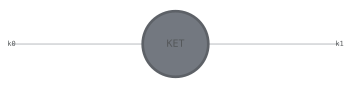

In [3]:
ket.draw()

This is pretty much like a n-dimensional array, but with a few key differences:

1. Methods manipulating dimensions use the names of indices, thus provided these are labelled correctly, their specific permutation doesn't matter.
2. The underlying `data` object can be anything that [autoray](https://github.com/jcmgray/autoray) supports - for example a symbolic or GPU array. These are passed around by reference and assumed to be immutable.
3. Binary operations such as `+` and `*` automatically align and broadcast the indices.

Some common [`Tensor`](quimb.tensor.tensor_core.Tensor) methods are:

- [`Tensor.reindex`](quimb.tensor.tensor_core.Tensor.reindex)
- [`Tensor.retag`](quimb.tensor.tensor_core.Tensor.retag)
- [`Tensor.fuse`](quimb.tensor.tensor_core.Tensor.fuse)
- [`Tensor.squeeze`](quimb.tensor.tensor_core.Tensor.squeeze)
- [`Tensor.gate`](quimb.tensor.tensor_core.Tensor.gate)
- [`Tensor.isel`](quimb.tensor.tensor_core.Tensor.isel)
- [`Tensor.new_ind`](quimb.tensor.tensor_core.Tensor.new_ind)
- [`Tensor.transpose`](quimb.tensor.tensor_core.Tensor.transpose)
- [`Tensor.trace`](quimb.tensor.tensor_core.Tensor.trace)
- [`Tensor.norm`](quimb.tensor.tensor_core.Tensor.norm)

:::{hint}
Many of these have inplace versions with an underscore appended,
so that `ket.transpose_('k1', 'k0')` would perform a
tranposition on `ket` directly, rather than making a new
tensor. The same convention is used for many
[`TensorNetwork`](quimb.tensor.tensor_core.TensorNetwork) methods.
:::

Let's also create some tensor paulis, with indices that act on the bell state and map the physical indices into two new ones:

In [4]:
X = qtn.Tensor(qu.pauli('X'), inds=('k0', 'b0'), tags=['PAULI', 'X', '0'])
Y = qtn.Tensor(qu.pauli('Y'), inds=('k1', 'b1'), tags=['PAULI', 'Y', '1'])

And finally, a random 'bra' to complete the inner product:

In [5]:
bra = qtn.Tensor(qu.rand_ket(4).reshape(2, 2), inds=('b0', 'b1'), tags=['BRA'])

Note how repeating an index name is all that is required to define a contraction.
If you want to join two tensors and have the index generated automatically
you can use the function [`qtn.connect`](quimb.tensor.tensor_core.connect).

:::{note}
Indices and tags should be strings - though this is currently not enforced.
A useful convention is to keep `inds` lower case, and `tags` upper.
Whilst the order of `tags` doesn't specifically matter, it is kept internally as a ordered set - [`oset`](quimb.utils.oset) - so that all operations are deterministic.
:::

## Creating Tensor Networks

We can now combine these into a [`TensorNetwork`](quimb.tensor.tensor_core.TensorNetwork) using the `&` operator overload:

In [6]:
TN = ket.H & X & Y & bra
TN

TensorNetwork(tensors=4, indices=4)

(note that `.H` conjugates the data but leaves the indices).
We could also use the [`TensorNetwork`](quimb.tensor.tensor_core.TensorNetwork)
constructor, which takes any sequence of tensors and/or tensor networks,
and has various advanced options.

The geometry of this network is completely defined by the repeated
indices forming edges between tensors, as well as arbitrary tags
identifying the tensors. The internal data of the tensor network
allows efficient access to any tensors based on their `tags` or `inds`.

:::{warning}
In order to naturally maintain networks geometry, bonds (repeated
indices) can be mangled when two tensor networks are combined.
As a result of this, only exterior indices are guaranteed to
keep their absolute value - since these define the overall object.
The [`qtn.bonds`](quimb.tensor.tensor_core.bonds) function can be used to
find the names of indices connecting tensors if explicitly required.
:::

Some common [`TensorNetwork`](quimb.tensor.tensor_core.TensorNetwork) methods
are:

- [`TensorNetwork.reindex`](quimb.tensor.tensor_core.TensorNetwork.reindex)
- [`TensorNetwork.retag`](quimb.tensor.tensor_core.TensorNetwork.retag)
- [`TensorNetwork.gate_inds`](quimb.tensor.tensor_core.TensorNetwork.gate_inds)
- [`TensorNetwork.isel`](quimb.tensor.tensor_core.TensorNetwork.isel)
- [`TensorNetwork.trace`](quimb.tensor.tensor_core.TensorNetwork.trace)
- [`TensorNetwork.contract`](quimb.tensor.tensor_core.TensorNetwork.contract)
- [`TensorNetwork.norm`](quimb.tensor.tensor_core.TensorNetwork.norm)

Note that many of these are shared with
[`Tensor`](quimb.tensor.tensor_core.Tensor), meaning it is possible to
write many agnostic functions that operate on either.

Any network can also be drawn using
[`TensorNetwork.draw`](quimb.tensor.tensor_core.TensorNetwork.draw), which will pick
a layout and also represent bond size as edge thickness, and optionally
color the nodes based on `tags`.

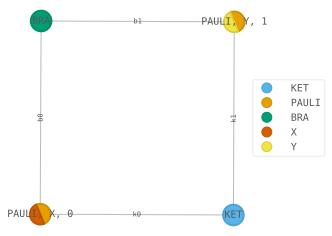

In [7]:
TN.draw(color=['KET', 'PAULI', 'BRA', 'X', 'Y'], figsize=(4, 4), show_inds='all')

Note the tags can be used to identify both paulis at once. But they could also be uniquely identified using their ``'X'`` and ``'Y'`` tags respectively:

A detailed guide to drawing can be found on the page {ref}`tensor-network-drawing`.

(tn-creation-graph-style)=

## Graph Orientated Tensor Network Creation

Another way to create tensor networks is define the tensors (nodes)
first and the make indices (edges) afterwards. This is mostly enabled
by the functions [`Tensor.new_ind`](quimb.tensor.tensor_core.Tensor.new_ind) and
[`Tensor.new_bond`](quimb.tensor.tensor_core.Tensor.new_bond). Take for example
making a small periodic matrix product state with bond dimension 7:

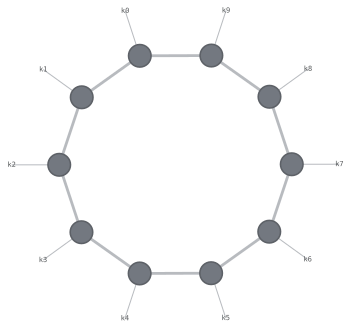

In [8]:
L = 10

# create the nodes, by default just the scalar 1.0
tensors = [qtn.Tensor() for _ in range(L)]

for i in range(L):
    # add the physical indices, each of size 2
    tensors[i].new_ind(f'k{i}', size=2)

    # add bonds between neighbouring tensors, of size 7
    tensors[i].new_bond(tensors[(i + 1) % L], size=7)

mps = qtn.TensorNetwork(tensors)
mps.draw()

:::{hint}
You can also add tensors or tensor networks in-place to an existing
tensor using the following syntax:

```python3
# add a copy of ``t``
tn &= t

# add ``t`` virtually
tn |= t
```
:::

## Contraction

Actually performing the implicit sum-of-products that a tensor network represents
involves *contraction*. Specifically, to turn a tensor network of $N$ tensors
into a single tensor with the same 'outer' shape and indices requires a sequence of
$N - 1$ pairwise contractions. The cost of doing these intermediate contractions
can be **very** sensitive to the exact sequence, or *'path'*, chosen. `quimb`
automates both the path finding stage and the actual contraction stage, but there is
a non-trivial tradeoff between how long one spends finding the path, and how long the
actual contraction takes.

:::{warning}
By default, `quimb` employs a basic greedy path
optimizer that has very little overhead, but won't nearly be optimal on large or complex
graphs. See {ref}`tensor-network-contraction` for more details.
:::

To fully contract a network we can use the `^` operator, and the `...` object:

In [9]:
TN ^ ...

np.complex128(-0.0017179944190445218-0.02655965070823639j)

Or if you only want to contract tensors with a specific set of tags, such as the two pauli operators,
supply a tag or sequence of tags:

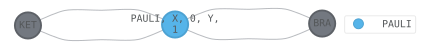

TensorNetwork([
    Tensor(shape=(2, 2), inds=('k0', 'k1'), tags=oset(['KET'])),
    Tensor(shape=(2, 2), inds=('b0', 'b1'), tags=oset(['BRA'])),
    Tensor(shape=(2, 2, 2, 2), inds=('k0', 'b0', 'k1', 'b1'), tags=oset(['PAULI', 'X', '0', 'Y', '1'])),
], tensors=3, indices=4)


In [10]:
TNc = TN ^ 'PAULI'
TNc.draw('PAULI')
print(TNc)

Note how the `tags` of the Paulis have been merged on the new tensor.

The are many other contraction related options detailed in {ref}`tensor-network-contraction`, but the
core function that all of these are routed through is [`tensor_contract`](quimb.tensor.tensor_core.tensor_contract).
If you need to pass contraction options, such as the path finding strategy kwarg `optimize`, you'll
need to call the method like `tn.contract(..., optimize='auto-hq')`.

One useful shorthand is the 'matmul' operator, `@`, which directly contracts two tensors:

In [11]:
ta = qtn.rand_tensor([2, 3], inds=['a', 'x'], tags='A')
tb = qtn.rand_tensor([4, 3], inds=['b', 'x'], tags='B')

# matrix multiplication but with indices aligned automatically
ta @ tb

Tensor(shape=(2, 4), inds=('a', 'b'), tags=oset(['A', 'B']))

Since the conjugate of a tensor network keeps the same outer indices,
this means that `tn.H @ tn` is always the frobenius norm squared
($\mathrm{Tr} A^{\dagger}A$) of any tensor network.

In [12]:
# get a normalized tensor network
psi = qtn.MPS_rand_state(10, 7)

# compute its norm squared
psi.H @ psi  # == (tn.H & tn) ^ ...

np.float64(1.0)

## Decomposition

A key part of many tensor network algorithms are various linear algebra
decompositions of tensors viewed as operators mapping one set of 'left'
indices to the remaining 'right' indices. This functionality is handled
by the core function [`tensor_split`](quimb.tensor.tensor_core.tensor_split).

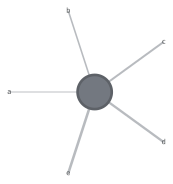

In [13]:
# create a tensor with 5 legs
t = qtn.rand_tensor([2, 3, 4, 5, 6], inds=['a', 'b', 'c', 'd', 'e'])
t.draw(figsize=(3, 3))

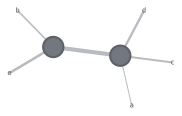

In [14]:
# split the tensor, by grouping some indices as 'left'
tn = t.split(['a', 'c', 'd'])
tn.draw(figsize=(3, 3))

There are many options that can be passed to {func}`~quimb.tensor.tensor_core.tensor_split` such as:

- which decomposition to use
- how or whether to absorb any singular values
- specific `tags` or `inds` to introduce

Often it is convenient to perform a decomposition within a tensor network, here we decompose
a central tensor of an MPS, introducing a new tensor that will sit on the bond:

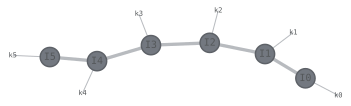

In [15]:
psi = qtn.MPS_rand_state(6, 10)
psi.draw()

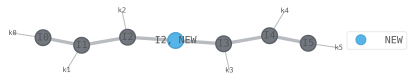

In [16]:
psi.split_tensor(
    # identify the tensor
    tags='I2',
    # here we give the right indices
    left_inds=None,
    right_inds=[psi.bond(2, 3)],
    # a new tag for the right factor
    rtags='NEW',
)

psi.draw('NEW')

To perform a truncated decomposition, one should specify some combination of
`max_bond` (a strict limit on the bond dimension) and/or `cutoff` (a dynamic
cutoff based on singular values):

In [17]:
# we can retrieve the truncation error by supplying this 'extras' dict:
info = {"error": None}

tn = t.split(
    ['a', 'c', 'd'],
    # keep no more than 10 singular values
    max_bond=10,
    # discard any singular values smaller than 1e-6 relative to the largest
    cutoff=1e-6,
    cutoff_mode="rel",
    # how to perform the decomposition, (svd is default)
    method="svd",
    info=info,
)

info

{'error': 10.492817606037953}

The error gives the Frobenius norm of the difference between the original and
truncated tensors: $||T - T'||_F = \sqrt{\langle (T-T')^\dagger, (T-T') \rangle}$,
we can check this explicitly using the [`distance`](quimb.tensor.fitting.tensor_network_distance) function:

In [18]:
t.distance(tn)

np.float64(10.492817606037955)

```{note}
The `rsum2` and `sum2` options for `cutoff_mode` compute the cutoff based on $\sum s_\mathrm{discarded}[i]^2$, **without** the square root of the frobenius norm.
```

### Gauging

A key aspect of tensor networks is the freedom to 'gauge' bonds - locally change
tensors whilst keeping the overall tensor network object invariant. For example,
contracting $G^{-1}$ and $G$ into adjacent tensors (you can do this
explicitly with [`TensorNetwork.insert_gauge`](quimb.tensor.tensor_core.TensorNetwork.insert_gauge)).

A common example is 'isometrizing' a tensor with respect to all but one of its
indices and absorbing an appropriate factor into its neighbor to take this transformation
into account. A common way to do this is via the QR decomposition:

<img src="figs/canonize-bond.png" width="1000px">

where the inward arrows imply:

<img src="figs/isometric-tensor.png" width="400px">

In `quimb` this is called 'canonizing' for short. When used in an MPS for example,
it can used to put the TN into a *canonical* form, but this is generally not possible
for 'loopy' TNs. The core function that performs this is
[`qtn.tensor_canonize_bond`](quimb.tensor.tensor_core.tensor_canonize_bond).

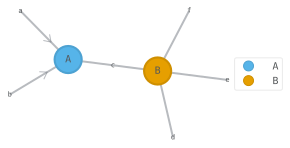

In [19]:
ta = qtn.rand_tensor([4, 4, 4], ['a', 'b', 'c'], 'A')
tb = qtn.rand_tensor([4, 4, 4, 4], ['c', 'd', 'e', 'f'], 'B')

qtn.tensor_canonize_bond(ta, tb)

(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='all')

You can also perform this within a TN with the method
[`TensorNetwork.canonize_between`](quimb.tensor.tensor_core.TensorNetwork.canonize_between)
or perform many such operations inwards on an automatically
generated spanning tree using
[`TensorNetwork.canonize_around`](quimb.tensor.tensor_core.TensorNetwork.canonize_around).

### Compressing

A similar operation is to 'compress' one or more bonds shared by
two tensors. The basic method for doing this is to contract
two 'reduced factors' from the neighboring tensors and perform
a truncated SVD on this central bond tensor before re-absorbing
the new decomposed parts either left or right:

<img src="figs/basic-compress.png" width="1000px">

The maximum bond dimension kept is often denoted $\chi$.
The core function that handles this is
[`qtn.tensor_compress_bond`](quimb.tensor.tensor_core.tensor_compress_bond).

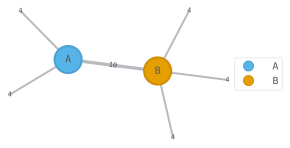

In [20]:
ta = qtn.rand_tensor([4, 4, 10], ['a', 'b', 'c'], 'A')
tb = qtn.rand_tensor([10, 4, 4, 4], ['c', 'd', 'e', 'f'], 'B')
(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='bond-size')

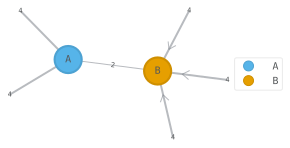

In [21]:
# perform the compression
qtn.tensor_compress_bond(ta, tb, max_bond=2, absorb='left')

# should now see the bond has been reduced in size to 2
(ta | tb).draw(['A', 'B'], figsize=(4, 4), show_inds='bond-size')

Again, there are many options for controlling the compression that can be found in
{func}`~quimb.tensor.tensor_core.tensor_compress_bond`, which in turn calls
{func}`~quimb.tensor.tensor_core.tensor_split` on the central factor.

In order to perform compressions in a tensor network based on tags, one can call
{meth}`~quimb.tensor.tensor_core.TensorNetwork.compress_between`, which also has
options for taking the environment into account and is one of the main drivers
for 2D contraction for example.

### `TNLinearOperator`

Tensor networks can represent very large multi-linear operators implicitly - these are
often too large to form a dense representation of explicitly. However, many iterative
algorithms exist that only require the action of this operator on a vector, and this can
be cast as a contraction that is usually much cheaper.

Consider the following contrived TN with overall shape
`(1000, 1000, 1000, 1000)`, but which is evidently low rank:

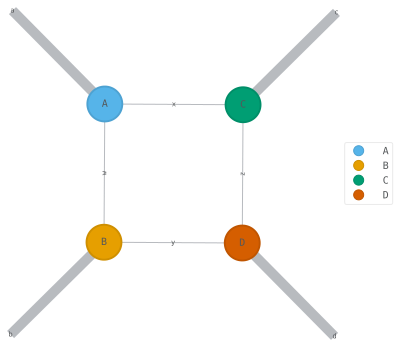

In [22]:
ta = qtn.rand_tensor([1000, 2, 2], inds=['a', 'w', 'x'], tags='A')
tb = qtn.rand_tensor([1000, 2, 2], inds=['b', 'w', 'y'], tags='B')
tc = qtn.rand_tensor([1000, 2, 2], inds=['c', 'x', 'z'], tags='C')
td = qtn.rand_tensor([1000, 2, 2], inds=['d', 'y', 'z'], tags='D')
tn = (ta | tb | tc | td)
tn.draw(['A', 'B', 'C', 'D'], show_inds='all')

View this as a {class}`~quimb.tensor.tensor_core.TNLinearOperator` which is a
subclass of a {class}`scipy.sparse.linalg.LinearOperator` and so can be supplied
anywhere they can:

In [23]:
tnlo = tn.aslinearoperator(['a', 'b'], ['c', 'd'])
tnlo

<1000000x1000000 TNLinearOperator with dtype=float64>

I.e. it maps a vector of size 1,000,000 spanning the indices `'a'` and `'b'`
to a vector of size 1,000,000 spanning the indices `'c'` and `'d'`.

We can supply it to iterative functions directly:

In [24]:
qu.eigvals(tnlo, k=1, which='LM')

array([1808.87538399+0.j])

Or the function {func}`~quimb.tensor.tensor_core.tensor_split` also
accepts a {class}`~quimb.tensor.tensor_core.TNLinearOperator` instead
of a {class}`~quimb.tensor.tensor_core.Tensor`.

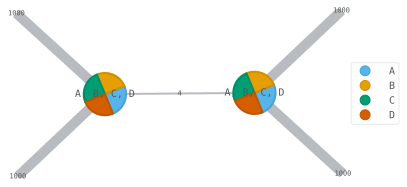

In [25]:
tn_decomp = qtn.tensor_split(
    tnlo,
    left_inds=tnlo.left_inds,
    right_inds=tnlo.right_inds,
    # make sure we supply a iterative method
    method='svds',  # {'rsvd', 'isvd', 'eigs', ...}
    max_bond=4,
)

tn_decomp.draw(['A', 'B', 'C', 'D'], show_inds='bond-size')

Again, this operation can be performed within a TN based on tags using the method
{meth}`~quimb.tensor.tensor_core.TensorNetwork.replace_with_svd`. Or you can treat
an entire tensor network as an operator to be decomposed with
{meth}`~quimb.tensor.tensor_core.TensorNetwork.split`.

:::{warning}
You are of course here still limited by the size of the left and right
vector spaces, which while generally are square root the size of the
dense operator, nonetheless grow exponentially in number of indices.
:::

## Selection

Many methods use `tags` to specify which tensors to operator on within a TN.
This is often used in conjuction with a `which` kwarg specifying how to match
the tags. The following illustrates the options for a 2D TN which has both
rows and columns tagged:

In [26]:
tn = qtn.TN2D_rand(5, 5, D=4)

Get tensors which have **all** of the tags:

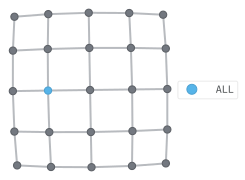

In [27]:
tn.select(tags=['X2', 'Y3'], which='all').add_tag('ALL')
tn.draw('ALL', figsize=(3, 3))

Get tensors which *don't* have **all** of the tags:

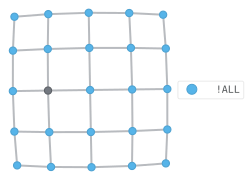

In [28]:
tn.select(tags=['X2', 'Y3'], which='!all').add_tag('!ALL')
tn.draw('!ALL', figsize=(3, 3))

Get tensors which have **any** of the tags:

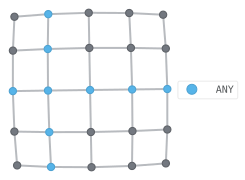

In [29]:
tn.select(tags=['X2', 'Y3'], which='any').add_tag('ANY')
tn.draw('ANY', figsize=(3, 3))

Get tensors which *don't* have **any** of the tags:

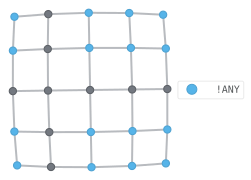

In [30]:
tn.select(tags=['X2', 'Y3'], which='!any').add_tag('!ANY')
tn.draw('!ANY', figsize=(3, 3))

Several methods exist for returning the tagged tensors directly:

- [`TensorNetwork.select`](quimb.tensor.tensor_core.TensorNetwork.select) - get a tagged region as a tensor network
- [`TensorNetwork.select_tensors`](quimb.tensor.tensor_core.TensorNetwork.select_tensors) - get tagged tensors directly
- [`TensorNetwork.partition`](quimb.tensor.tensor_core.TensorNetwork.partition) - partition into a two tensor networks
- [`TensorNetwork.partition_tensors`](quimb.tensor.tensor_core.TensorNetwork.partition_tensors) - partition into two groups of tensors directly
- [`TensorNetwork.select_local`](quimb.tensor.tensor_core.TensorNetwork.select_local) - get a local region as a tensor network

Using the `tn[tags]` syntax is like calling `tn.select_tensors(tags, which='all')`:

In [31]:
tn['X2', 'Y3']

Tensor(shape=(4, 4, 4, 4), inds=('_4e9944AAABa', '_4e9944AAABc', '_4e9944AAABd', '_4e9944AAABU'), tags=oset(['I2,3', 'X2', 'Y3', 'ALL', 'ANY']))

Although some special tensor networks also accept a lattice coordinate here as well:

In [32]:
tn[2, 3]

Tensor(shape=(4, 4, 4, 4), inds=('_4e9944AAABa', '_4e9944AAABc', '_4e9944AAABd', '_4e9944AAABU'), tags=oset(['I2,3', 'X2', 'Y3', 'ALL', 'ANY']))

:::{hint}
You can iterate over all tensors in a tensor network like so:

```python3
for t in tn:
    ...
```
:::

Behind the scenes, tensors in a tensor network are stored using a unique `tid` - an integer
denoting which node they are in the network. See {ref}`tensor-network-design` for a more low
level description.

### Virtual vs Copies

An important concept when selecting tensors from tensor networks is whether the operation
takes a copy of the tensors, or is simply viewing them 'virtually'. In the examples above
because {meth}`~quimb.tensor.tensor_core.TensorNetwork.select` defaults to `virtual=True`,
when we modified the tensors by adding the tags `('ALL', '!ALL', 'ANY', '!ANY')`, we
are modifying the tensors in the original network too. Similarly, when we construct a
tensor network like so:

In [33]:
tn = qtn.TensorNetwork([ta, tb, tc, td], virtual=True)

which is equivalent to

In [34]:
tn = (ta | tb | tc | td)

the new TN is *viewing* those tensors and so changes to them will affect ``tn``
and vice versa. Note this is *not* the default behaviour.

:::{warning}
The underlying tensor arrays - `t.data` - are always assumed to be immutable
and for efficiency are never copied by default in `quimb`.
:::

## Modification

Whilst many high level functions handle all the tensor modifications for you, at some
point you will likely want to directly update, for example, the data in a
{class}`~quimb.tensor.tensor_core.Tensor`. The low-level method for performing arbitrary
changes to a tensors `data`, `inds` and `tags` is
{meth}`~quimb.tensor.tensor_core.Tensor.modify`.

The reason that this is encapsulated thus, which is something to be aware of, is so that
the tensor can let any tensor networks viewing it know of the changes. For example, often
we want to iterate over tensors in a TN and change them on this atomic level, but not have
to worry about the TN's efficient maps which keep track of all the indices and tags going
out of sync.

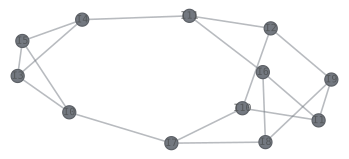

In [35]:
tn = qtn.TN_rand_reg(12, 3, 3, seed=42)
tn.draw()

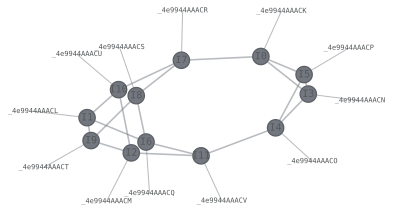

In [36]:
# add a random dangling index to each tensor
for t in tn:
    t.new_ind(qtn.rand_uuid(), size=2)

tn.draw()

In [37]:
# the TN efficiently keeps track of all indices and tags still
tn.outer_inds()

('_4e9944AAACK',
 '_4e9944AAACL',
 '_4e9944AAACM',
 '_4e9944AAACN',
 '_4e9944AAACO',
 '_4e9944AAACP',
 '_4e9944AAACQ',
 '_4e9944AAACR',
 '_4e9944AAACS',
 '_4e9944AAACT',
 '_4e9944AAACU',
 '_4e9944AAACV')

See the page {ref}`tensor-network-design` for more details.